<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/notebooks/2021deep_dream_corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Dream サンプル
- Date: 2021-0321
- author: 浅川伸一

西尾先生のご指摘により，バージョンが古くなって動作しなくなっている問題を回避したバージョン

In [ ]:
print('# 西尾先生にお送りしたバージョンと本質的な差異はこのセルだけです')
import tensorflow as tf

# 次行は，バージョン 1.0 の keras を動かすために必要
tf.compat.v1.disable_eager_execution()
import tensorflow.keras as keras

# 古いバージョンの keras ではなく Tensorflow に統合された新バージョンの keras を用いる
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras import backend as K
from tensorflow.keras.applications import inception_v3

# その他必要なライブラリの輸入
import numpy as np
import scipy
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print('# ディープドリームで加工処理するためのサンプル画像をローカルの Mac や PC からアップロードします。')
print('# このセルを実行すると表示されるボタンの Choose Files を 押下し ローカルファイルから画像を選んでアップロードしてください')
from google.colab import files
uploaded = files.upload()

In [ ]:
print('# 上のセルでアップロードした画像のファイル名を次行に入力します')
print('# dog.jpg になっていますので，アップロードした画像のファイル名に書き換えてください')
base_image_path = "dog.jpg"
#result_prefix = args.result_prefix
result_prefix = "dog_deepdreamed"

# 上のセルでアップロードした画像のファイル名を次行に入力します
# dog.jpg になっていますので，アップロードした画像のファイル名に書き換えてください


In [ ]:
"""
ディープドリームの画像変換に用いる，各層の重み係数を指定
各層のニューロンの活性値を最大化するために，層の名前と、その層で最大化しようとする最終損失の重み係数を指定します。
これらの設定を微調整することで異なる視覚効果を得ることが可能です
"""
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}

In [ ]:
def preprocess_image(image_path):
    """画像の前処理"""
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    """入力画像をディープドリームモデルで扱えるように変換"""
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

K.set_learning_phase(0)

In [ ]:
# イメージネット画像データセットを用いて訓練れた，訓練済のニューラルネットワーク係数
# の読み込み，最終層は不要なので読み込まない
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input
print('Model loaded.')

# 各層の名前を辞書として取得しておく
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# 訓練に必要となる損失関数 (目的関数) の定義
loss = K.variable(0.)
for layer_name in settings['features']:
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # 画像の隅，周辺部分のアーチファクトを取り去る処理
    scaling = K.prod(K.cast(K.shape(x), 'float32'))

    # L2 正則化
    if K.image_data_format() == 'channels_first':
        loss = loss + coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss = loss + coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# 勾配降下法のための勾配
grads = K.gradients(loss, dream)[0]
# 正則化
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# 入力画像から勾配と損失値を計算するための準備
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


"""計算手順の説明:
- 元画像の読み込み
- 処理スケール（＝画像の形）を 最小から最大まで複数のスケールで準備する
- 元画像のサイズを最小の画像スケールに変更
- 各画像スケールについて、最小さいから逐次以下の処理を実施
    - 勾配の上昇を計算
    - 画像を次の画像スケールに拡大
    - 拡大した際に失われた画像の詳細をを元画像から再注入
- 元の画像サイズまで繰り返して終了

画像スケールを拡大する際に失われた詳細を得るには，単純に 元の画像を縮小し，再び拡大する。
その結果の画像とスケールした画像と比較する
"""

In [ ]:
# ハイパーパラメータの定義。これの値を変化させることで得られる画像も変化します
step = 0.01  # 勾配のステップ幅
num_octave = 3  # スケール拡大する際の分割数 
octave_scale = 1.4  # スケール間のサイズ比
iterations = 20  # 各スケールでの最大繰り返し数
max_loss = 10.

In [ ]:
print('#  元画像を表示します')
plt.figure(figsize=(10,8))   # 縦横の画像サイズ，単位はインチ
plt.axis('off')  # 軸名の非表示。on なら軸を描画する
img = preprocess_image(base_image_path)  # 元画像を読み込む
plt.imshow(img[0])   # 表示

In [ ]:
print('# ディープドリーム変換の実施 数分の時間を要します')
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

In [ ]:
deprocessed = deprocess_image(np.copy(img))
save_img(result_prefix + '.png', deprocessed)

In [ ]:
print('# このセルを実行すると処理結果の画像をローカルディスク(Mac, PC)  に保存できます')
filename = result_prefix + '.png'
files.download(filename)

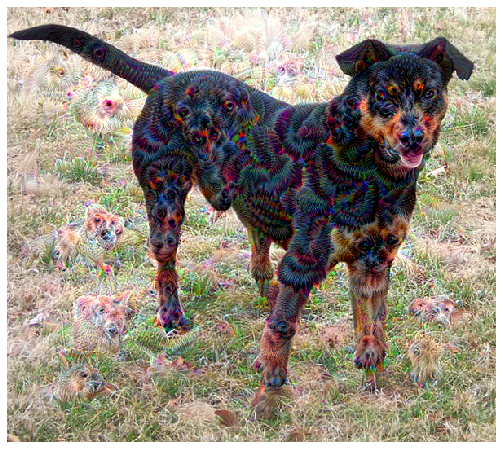

In [ ]:
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(plt.imread(result_prefix+'.png'))